In [39]:
import sys

sys.path.append("../")

from scripts.direct_training import direct_training
from scripts.fine_tuning import fine_tuning

pre_trained = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-SYNTH-23M:reasonable",
        n_train=10_000,
    )
)

pre_trained_models = {row.labels: row.id for row in pre_trained.itertuples()}
pre_trained_models

{'ace': '23.06.08-20.33.15-394025',
 'gap20': '23.06.09-08.13.03-677890',
 'edip': '23.06.09-22.16.54-046769',
 'lcbop': '23.06.13-08.37.46-604921'}

In [40]:
import pandas as pd
from IPython.display import display

finetuned_results = {}

for label, id in pre_trained_models.items():
    df = fine_tuning.to_dataframe(
        config=dict(
            pretrain_id=id,
            finetune_dataset="C-GAP-17",
            finetune_labels="dft",
            checkpoint="best",
        )
    )
    # df = df[df.seed.isin((1, 2, 42))]
    finetuned_results[label] = df

pd.DataFrame(
    {
        label: df.groupby("n_finetune").count().id
        for label, df in finetuned_results.items()
        if label != "qsnap"
    }
).T

n_finetune,25,50,100,200,400,800,1600,3200
ace,5,5,5,5,5,5,5,5
gap20,5,5,5,5,5,5,5,5
edip,5,5,5,5,5,5,5,5
lcbop,5,5,5,5,5,5,5,5


In [41]:
direct_results = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-GAP-17",
        labels="dft",
    )
)

# direct_results = direct_results[direct_results.seed.isin((1, 2, 42))]

pd.DataFrame(direct_results.groupby("n_train").count().id).T


n_train,25,50,100,200,400,800,1600,3200
id,5,5,5,5,5,5,5,5


In [42]:
import matplotlib.pyplot as plt


def cleanup(ax, yticks=None):
    xticks = list(direct_results.n_train.unique())
    ax.set_xscale("log")
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel("Number of Training Structures")

    if yticks is None:
        yticks = [round(y) for y in ax.get_yticks()]
    ax.set_yscale("log")
    ax.set_yticks(yticks, yticks)

    ax.minorticks_off()
    # move spines apart
    ax.spines["bottom"].set_position(("outward", 10))
    ax.spines["bottom"].set_bounds(xticks[0], xticks[-1])

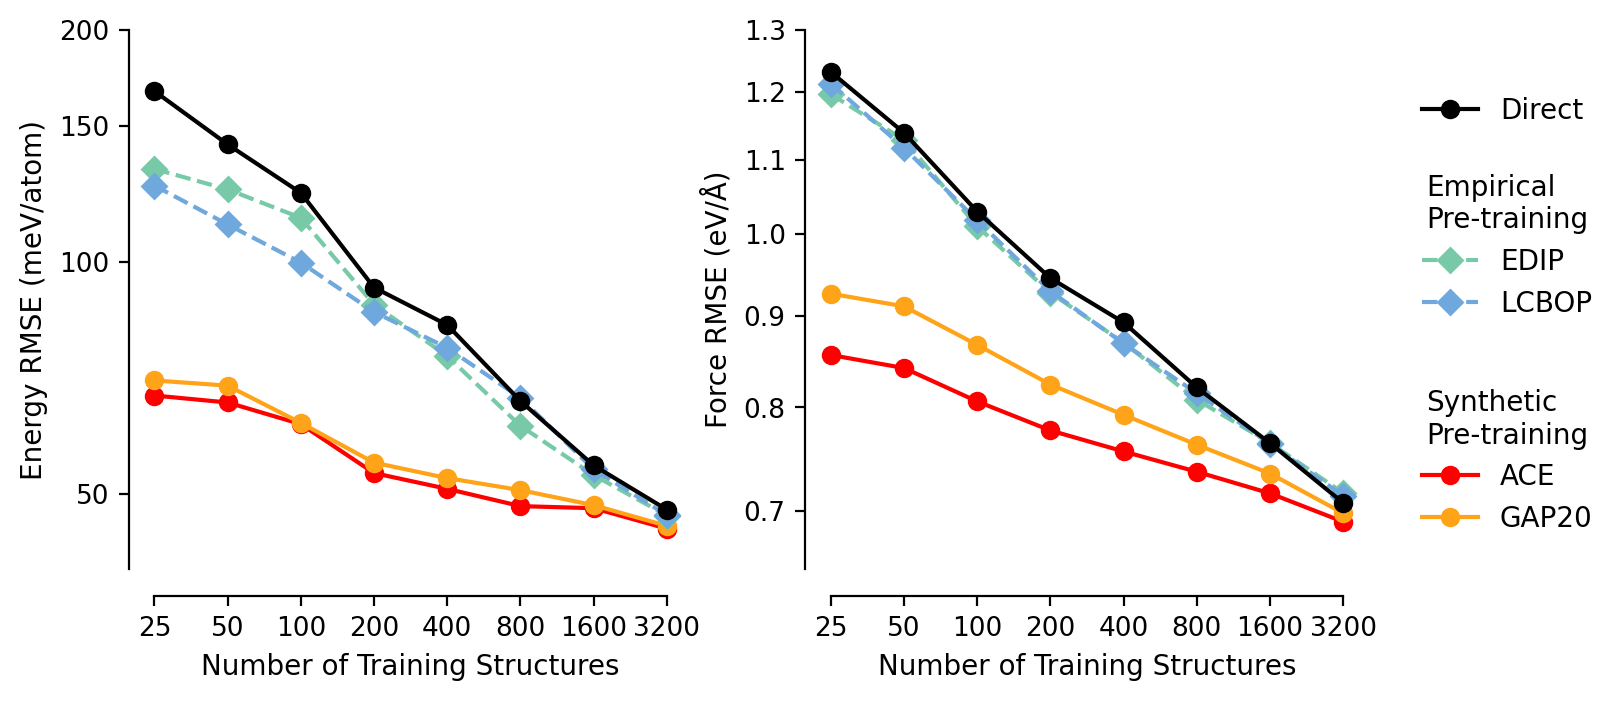

In [43]:
from collections import defaultdict
import matplotlib.pyplot as plt
from plotting_utils import style_defaults, colours, empirical as empirical_labels, synthetic as synthetic_labels
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(style_defaults)

fig, (energy_ax, force_ax ) = plt.subplots(ncols=2, figsize=(8, 3.5))

direct_style = "-o"
empirical_style = "--D"
synthetic_style = "-o"

## DIRECT TRAINING

lines = defaultdict(dict)

def plot_results(results, style, colour):
    col_name = "n_train" if "n_train" in results else "n_finetune"
    results = results.groupby(col_name)[["test_per_atom_energy_rmse", "test_force_rmse"]].min().reset_index()
    energy_ax.plot(
        results[col_name],
        results.test_per_atom_energy_rmse * 1000,
        style,
        color=colour,
    )

    line, = force_ax.plot(
        results.n_train if "n_train" in results else results.n_finetune,
        results.test_force_rmse,
        style,
        color=colour,
    )
    return line



## FINETUNING

for label, results in finetuned_results.items():
    if label == "qsnap":
        continue
    colour = colours[label]
    style = synthetic_style if label in synthetic_labels else empirical_style
    flag = "synthetic" if label in synthetic_labels else "empirical"
    lines[flag][label] = plot_results(results, style, colour)

direct_line = plot_results(direct_results, direct_style, colours["dft"])

cleanup(energy_ax, yticks=[50, 100, 150, 200])
energy_ax.set_ylabel("Energy RMSE (meV/atom)")
cleanup(force_ax, yticks=[0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3])
force_ax.set_ylabel("Force RMSE (eV/Å)")

energy_ax.set_ylim(40, 200)
force_ax.set_ylim(0.65, 1.3)

direct_leg = plt.legend(
    (direct_line,),
    ("Direct",),
    bbox_to_anchor=(1.05, 0.85),
    loc="center left",
    fancybox=False,
)


emp_leg = plt.legend(
    lines["empirical"].values(),
    [l.upper() for l in lines["empirical"].keys()],
    title="Empirical\nPre-training",
    bbox_to_anchor=(1.05, 0.6),
    loc="center left",
    fancybox=False,
)


syn_leg = plt.legend(
    lines["synthetic"].values(),
    [l.upper() for l in lines["synthetic"].keys()],
    title="Synthetic\nPre-training",
    bbox_to_anchor=(1.05, 0.2),
    loc="center left",
    fancybox=False,
)

fig.add_artist(direct_leg)
fig.add_artist(emp_leg)

plt.savefig("../figures/pre-train-source.svg", bbox_inches="tight", transparent=True)

# Table Generation

In [44]:
finetuned_results = {}

for label, id in pre_trained_models.items():
    df = fine_tuning.to_dataframe(
        config=dict(
            pretrain_id=id,
            finetune_dataset="C-GAP-17",
            finetune_labels="dft",
            checkpoint="best",
        )
    )
    finetuned_results[label] = df


def get_performance(df, metric, groupby="n_finetune"):
    result = df.groupby(groupby)[metric].agg(["mean", "std"]).reset_index()
    return (
        (result["mean"] * 1000).round(1).astype(str)
        + " ± "
        + (result["std"] * 1000).round(1).astype(str)
    )


df = pd.DataFrame(
    {
        label: get_performance(df, "test_per_atom_energy_rmse", groupby="n_finetune")
        for label, df in finetuned_results.items()
        if label != "qsnap"
    }
).T
df.columns = [25, 50, 100, 200, 400, 800, 1600, 3200]

# get the same for the direct results
direct_results = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-GAP-17",
        labels="dft",
    )
)


direct_df = pd.DataFrame(
    {
        "direct": get_performance(
            direct_results, "test_per_atom_energy_rmse", groupby="n_train"
        ),
    }
).T
direct_df.columns = [25, 50, 100, 200, 400, 800, 1600, 3200]

df = pd.concat([df, direct_df])
df = df.T[["direct", "edip", "lcbop", "gap20", "ace"]]
df

,direct,edip,lcbop,gap20,ace
25,192.3 ± 21.2,136.4 ± 5.8,129.9 ± 3.9,73.1 ± 3.6,70.3 ± 2.8
50,166.1 ± 15.5,134.6 ± 7.1,119.0 ± 4.7,69.7 ± 1.2,71.8 ± 6.9
100,129.2 ± 5.3,115.6 ± 1.4,106.3 ± 6.4,63.1 ± 1.1,63.0 ± 1.5
200,96.1 ± 2.8,90.9 ± 2.7,87.1 ± 0.8,55.5 ± 0.4,53.8 ± 0.6
400,87.2 ± 3.5,83.3 ± 6.2,80.6 ± 2.3,52.8 ± 0.6,51.9 ± 1.0
800,69.1 ± 2.8,71.1 ± 19.2,68.1 ± 1.3,51.4 ± 0.8,50.2 ± 1.7
1600,56.0 ± 1.5,56.1 ± 4.0,54.9 ± 0.8,49.2 ± 0.8,48.2 ± 0.4
3200,51.0 ± 6.2,88.2 ± 72.3,48.2 ± 0.9,45.9 ± 0.5,45.4 ± 0.4


In [45]:
# convert the ^df into a latex table
print(df.style.to_latex().replace("±", "$\pm$"))


\begin{tabular}{llllll}
 & direct & edip & lcbop & gap20 & ace \\
25 & 192.3 $\pm$ 21.2 & 136.4 $\pm$ 5.8 & 129.9 $\pm$ 3.9 & 73.1 $\pm$ 3.6 & 70.3 $\pm$ 2.8 \\
50 & 166.1 $\pm$ 15.5 & 134.6 $\pm$ 7.1 & 119.0 $\pm$ 4.7 & 69.7 $\pm$ 1.2 & 71.8 $\pm$ 6.9 \\
100 & 129.2 $\pm$ 5.3 & 115.6 $\pm$ 1.4 & 106.3 $\pm$ 6.4 & 63.1 $\pm$ 1.1 & 63.0 $\pm$ 1.5 \\
200 & 96.1 $\pm$ 2.8 & 90.9 $\pm$ 2.7 & 87.1 $\pm$ 0.8 & 55.5 $\pm$ 0.4 & 53.8 $\pm$ 0.6 \\
400 & 87.2 $\pm$ 3.5 & 83.3 $\pm$ 6.2 & 80.6 $\pm$ 2.3 & 52.8 $\pm$ 0.6 & 51.9 $\pm$ 1.0 \\
800 & 69.1 $\pm$ 2.8 & 71.1 $\pm$ 19.2 & 68.1 $\pm$ 1.3 & 51.4 $\pm$ 0.8 & 50.2 $\pm$ 1.7 \\
1600 & 56.0 $\pm$ 1.5 & 56.1 $\pm$ 4.0 & 54.9 $\pm$ 0.8 & 49.2 $\pm$ 0.8 & 48.2 $\pm$ 0.4 \\
3200 & 51.0 $\pm$ 6.2 & 88.2 $\pm$ 72.3 & 48.2 $\pm$ 0.9 & 45.9 $\pm$ 0.5 & 45.4 $\pm$ 0.4 \\
\end{tabular}



# Source Accuracy

In [46]:
from src.data import get_file_path, ensure_dataset_exists
from ase.io import read
import numpy as np


def get_test_set_labels(source):
    ensure_dataset_exists("C-GAP-17", source)
    test_set = get_file_path("C-GAP-17", source, "test")
    structures = read(test_set, ":")
    prefix = f"{source}_" 
    predictions = []
    for structure in structures:
        pred = {
            "energy": structure.info[f"{prefix}energy"],
            "forces": structure.arrays[f"{prefix}force"],
        }
        predictions.append(pred)
    return predictions

labels = {
    source: get_test_set_labels(source)
    for source in ("dft", "ace", "gap17", "lcbop", "edip", "gap20")
}

In [47]:
import pandas   as pd

def energies_and_forces(predictions):
    N = np.array([len(s["forces"]) for s in predictions])
    ref_energies = np.array([s["energy"] for s in predictions]) / N
    ref_forces = np.vstack([s["forces"] for s in predictions])
    # subtract arbitrary offset
    e0 = np.mean(ref_energies)
    ref_energies -= e0

    return ref_energies, ref_forces

def get_rmse(reference, predictions):
    ref_energies, ref_forces = energies_and_forces(reference)
    pred_energies, pred_forces = energies_and_forces(predictions)

    energy_rmse = np.sqrt(np.mean((ref_energies - pred_energies) ** 2))
    force_rmse = np.sqrt(np.mean((ref_forces - pred_forces) ** 2))

    return {"Energy (meV)": energy_rmse * 1_000, "Force (eV/Å)": force_rmse}

rmses = {
    source: get_rmse(labels["dft"], labels[source])
    for source in ("ace", "gap20", "lcbop", "edip")
}
pd.DataFrame(rmses).T.round(3)

,Energy (meV),Force (eV/Å)
ace,90.723,0.732
gap20,83.990,1.092
lcbop,666.530,9.289
edip,496.161,6.799


In [48]:
from src.evaluate import get_model_predictions

test_structures = read("../data/processed/C-GAP-17/dft/test.extxyz", ":")

pre_trained_predictions = {
    label: get_model_predictions(id, test_structures)
    for label, id in pre_trained_models.items()
}

In [49]:
rmses = {
    source: get_rmse(labels["dft"], pre_trained_predictions[source])
    for source in ("ace", "gap20", "lcbop", "edip")
}
pd.DataFrame(rmses).T.round(3)

,Energy (meV),Force (eV/Å)
ace,112.933,0.881
gap20,102.646,1.125
lcbop,625.587,9.230
edip,489.632,9.391
